<a href="https://colab.research.google.com/github/unica-mlsec/mlsec/blob/main/notebooks/advx-challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Adversarial Examples

Adversarial examples, also known as evasion attacks, are intentionally-perturbed input samples aimed to mislead classification at test time. [1,2].

These attacks are formulated as optimization problems that can be solved via gradient-based optimizers.

Here, we will compute adversarial examples by minimizing a loss function $L$ on a target label $y_t$ (different from the true class), under manipulation constraints, as given below:

$$
\begin{eqnarray}
    \mathbf x^\star \in {\arg\min}_{\mathbf x} && L(\mathbf x, y_t, \theta) \, \\
    {\rm s.t. } && \| \mathbf x- \mathbf x_0\|_2 \leq \varepsilon \, , \\
    && \mathbf x_{\rm lb} \preceq \mathbf x \preceq \mathbf x_{\rm ub} \, .
\end{eqnarray}
$$

The first constraint imposes that the adversarial perturbation will not be larger than $\varepsilon$ (measured in $\ell_2$ norm).
The second constraint is a box constraint to enforce the adversarial image not to exceed the range 0-255 (or 0-1, if the input pixels are scaled).


We solve this problem with a *projected* gradient-descent algorithm below, which iteratively projects the adversarial image on the feasible domain to ensure that the constraints remain valid.

The attack is meant to manipulate the input pixels of the initial image. To this end, we will need to explicitly account for the transform/scaling performed before passing the input sample to the neural network. In particular, at each iteration, we will map the image from the pixel space onto the transformed/scaled space, update the attack point along the gradient direction in that space, project the modified image back onto the input pixel space (using an inverse-transformation function), and apply box and $\ell_2$ constraints in the input space.


**References**
1.   C. Szegedy et al.,  Intriguing Properties of Neural Networks, ICLR 2014, https://arxiv.org/abs/1312.6199
2.   B. Biggio et al., Evasion Attacks against Machine Learning at Test Time, ECML PKDD 2013, https://arxiv.org/abs/1708.06131


In [1]:
!npx degit https://github.com/zangobot/adversarial_challenge --force
!pip install -r requirements.txt

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏Need to install the following packages:
degit@2.8.4
Ok to proceed? (y) y

⠙⠹⠸⠼⠴⠦> destination directory is not empty. Using --force, continuing
> cloned zangobot/adversarial_challenge#HEAD
⠙Requirement already satisfied: torch in /usr/local/lib/python3.12/dist-packages (from -r requirements.txt (line 1)) (2.8.0+cu126)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.7 MB/s eta 0:00:00


In [39]:
import numpy as np
import torch
from torchvision import datasets

from mnist_model import SimpleNet

net = SimpleNet().load_pretrained_mnist('mnist_net.pth')
mnist = datasets.MNIST(root='.', download=True, train=False, transform=net.get_transform())
sample, label = mnist[350]
sample = sample.view((1, *sample.shape))
target_label = torch.LongTensor([2])

print(f'Original label: {label}')
iterations = 20
eps = 1.5
loss = torch.nn.CrossEntropyLoss()
step_size = 0.5

x_adv = sample.clone()
x_adv = x_adv.requires_grad_()

for i in range(iterations):
	scores = net(x_adv)

	output = loss(scores, target_label)
	print("Iter: " +str(i) + ", Loss: " +str(output.detach().numpy()))

	output.backward()
	gradient = x_adv.grad
	gradient = gradient / torch.norm(gradient, p=2)
	x_adv.data = x_adv.data - step_size * gradient
	x_adv.data = torch.clamp(x_adv, 0, 1)
	if torch.norm(x_adv - sample, p=2) > eps:
		delta = x_adv.data - sample.data
		delta = delta / torch.norm(delta, p=2)
		x_adv.data = sample.data + eps*delta.data
	x_adv.grad.data.zero_()

print(f'Adv loss: {output}')
print(f'Adv label: {scores.argmax(dim=-1)}')

Original label: 1
Iter: 0, Loss: 12.278714
Iter: 1, Loss: 8.8288145
Iter: 2, Loss: 5.6479564
Iter: 3, Loss: 4.1994343
Iter: 4, Loss: 3.1781592
Iter: 5, Loss: 1.7518425
Iter: 6, Loss: 1.75196
Iter: 7, Loss: 1.4824663
Iter: 8, Loss: 1.4221342
Iter: 9, Loss: 0.9884441
Iter: 10, Loss: 0.8565708
Iter: 11, Loss: 0.7831985
Iter: 12, Loss: 0.7195021
Iter: 13, Loss: 0.7492168
Iter: 14, Loss: 0.6788766
Iter: 15, Loss: 0.69354886
Iter: 16, Loss: 0.7553336
Iter: 17, Loss: 0.7089945
Iter: 18, Loss: 0.676334
Iter: 19, Loss: 0.68956435
Adv loss: 0.6895643472671509
Adv label: tensor([2])


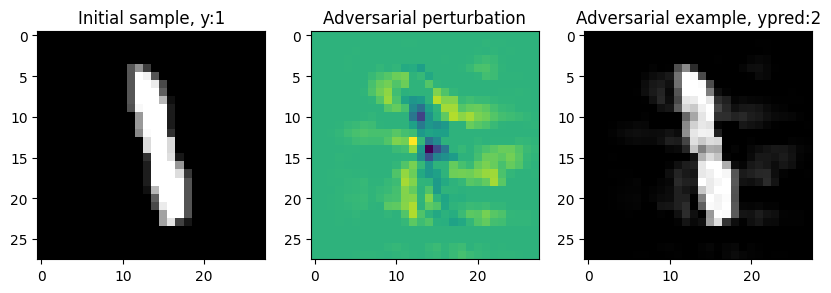

In [40]:
# Visualize MNIST image
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.imshow(sample.squeeze().numpy(), cmap='gray')
plt.title("Initial sample, y:" +str(label))
plt.subplot(1,3,2)
delta = x_adv.squeeze().detach().numpy() - sample.squeeze().numpy()
plt.imshow(delta)
plt.title("Adversarial perturbation")
plt.subplot(1,3,3)
plt.title("Adversarial example, ypred:" +str(scores.argmax(dim=-1).squeeze().numpy()))
plt.imshow(x_adv.squeeze().detach().numpy(), cmap='gray')
plt.show()
